In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
#from common import dprint
# from detectors import Detectors
# from tracker import Tracker
# from kalman_filter import KalmanFilter
from scipy.optimize import linear_sum_assignment
import copy

In [2]:
debug = 0

class Detectors(object):
    """Detectors class to detect objects in video frame
    Attributes:
        None
    """
    def __init__(self):
        """Initialize variables used by Detectors class
        Args:
            None
        Return:
            None
        """
        self.fgbg = cv2.createBackgroundSubtractorMOG2()

    def Detect(self, frame):
        """Detect objects in video frame using following pipeline
            - Convert captured frame from BGR to GRAY
            - Perform Background Subtraction
            - Detect edges using Canny Edge Detection
              http://docs.opencv.org/trunk/da/d22/tutorial_py_canny.html
            - Retain only edges within the threshold
            - Find contours
            - Find centroids for each valid contours
        Args:
            frame: single video frame
        Return:
            centers: vector of object centroids in a frame
        """

        # Convert BGR to GRAY
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if (debug == 1):
            cv2.imshow('gray', gray)

        # Perform Background Subtraction
        fgmask = self.fgbg.apply(gray)

        if (debug == 0):
            cv2.imshow('bgsub', fgmask)

        # Detect edges
        edges = cv2.Canny(fgmask, 50, 190, 3)

        if (debug == 1):
            cv2.imshow('Edges', edges)

        # Retain only edges within the threshold
        ret, thresh = cv2.threshold(edges, 127, 255, 0)

        # Find contours
        _, contours, hierarchy = cv2.findContours(thresh,
                                                  cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_SIMPLE)

        if (debug == 0):
            cv2.imshow('thresh', thresh)

        centers = []  # vector of object centroids in a frame
        # we only care about centroids with size of bug in this example
        # recommended to be tunned based on expected object size for
        # improved performance
        blob_radius_thresh = 8
        # Find centroid for each valid contours
        for cnt in contours:
            try:
                # Calculate and draw circle
                (x, y), radius = cv2.minEnclosingCircle(cnt)
                centeroid = (int(x), int(y))
                radius = int(radius)
                if (radius > blob_radius_thresh):
                    cv2.circle(frame, centeroid, radius, (0, 255, 0), 2)
                    b = np.array([[x], [y]])
                    centers.append(np.round(b))
            except ZeroDivisionError:
                pass

        # show contours of tracking objects
        # cv2.imshow('Track Bugs', frame)

        return centers

In [3]:
class KalmanFilter(object):
    """Kalman Filter class keeps track of the estimated state of
    the system and the variance or uncertainty of the estimate.
    Predict and Correct methods implement the functionality
    Reference: https://en.wikipedia.org/wiki/Kalman_filter
    Attributes: None
    """

    def __init__(self):
        """Initialize variable used by Kalman Filter class
        Args:
            None
        Return:
            None
        """
        self.dt = 0.005  # delta time

        self.A = np.array([[1, 0], [0, 1]])  # matrix in observation equations
        self.u = np.zeros((2, 1))  # previous state vector

        # (x,y) tracking object center
        self.b = np.array([[0], [255]])  # vector of observations

        self.P = np.diag((3.0, 3.0))  # covariance matrix
        self.F = np.array([[1.0, self.dt], [0.0, 1.0]])  # state transition mat

        self.Q = np.eye(self.u.shape[0])  # process noise matrix
        self.R = np.eye(self.b.shape[0])  # observation noise matrix
        self.lastResult = np.array([[0], [255]])

    def predict(self):
        """Predict state vector u and variance of uncertainty P (covariance).
            where,
            u: previous state vector
            P: previous covariance matrix
            F: state transition matrix
            Q: process noise matrix
        Equations:
            u'_{k|k-1} = Fu'_{k-1|k-1}
            P_{k|k-1} = FP_{k-1|k-1} F.T + Q
            where,
                F.T is F transpose
        Args:
            None
        Return:
            vector of predicted state estimate
        """
        # Predicted state estimate
        self.u = np.round(np.dot(self.F, self.u))
        # Predicted estimate covariance
        self.P = np.dot(self.F, np.dot(self.P, self.F.T)) + self.Q
        self.lastResult = self.u  # same last predicted result
        return self.u

    def correct(self, b, flag):
        """Correct or update state vector u and variance of uncertainty P (covariance).
        where,
        u: predicted state vector u
        A: matrix in observation equations
        b: vector of observations
        P: predicted covariance matrix
        Q: process noise matrix
        R: observation noise matrix
        Equations:
            C = AP_{k|k-1} A.T + R
            K_{k} = P_{k|k-1} A.T(C.Inv)
            u'_{k|k} = u'_{k|k-1} + K_{k}(b_{k} - Au'_{k|k-1})
            P_{k|k} = P_{k|k-1} - K_{k}(CK.T)
            where,
                A.T is A transpose
                C.Inv is C inverse
        Args:
            b: vector of observations
            flag: if "true" prediction result will be updated else detection
        Return:
            predicted state vector u
        """

        if not flag:  # update using prediction
            self.b = self.lastResult
        else:  # update using detection
            self.b = b
        C = np.dot(self.A, np.dot(self.P, self.A.T)) + self.R
        K = np.dot(self.P, np.dot(self.A.T, np.linalg.inv(C)))

        self.u = np.round(self.u + np.dot(K, (self.b - np.dot(self.A,
                                                              self.u))))
        self.P = self.P - np.dot(K, np.dot(C, K.T))
        self.lastResult = self.u
        return self.u

In [8]:
class Track(object):
    """Track class for every object to be tracked
    Attributes:
        None
    """

    def __init__(self, prediction, trackIdCount):
        """Initialize variables used by Track class
        Args:
            prediction: predicted centroids of object to be tracked
            trackIdCount: identification of each track object
        Return:
            None
        """
        self.track_id = trackIdCount  # identification of each track object
        self.KF = KalmanFilter()  # KF instance to track this object
        self.prediction = np.asarray(prediction)  # predicted centroids (x,y)
        self.skipped_frames = 0  # number of frames skipped undetected
        self.trace = []  # trace path


class Tracker(object):
    """Tracker class that updates track vectors of object tracked
    Attributes:
        None
    """

    def __init__(self, dist_thresh, max_frames_to_skip, max_trace_length,
                 trackIdCount):
        """Initialize variable used by Tracker class
        Args:
            dist_thresh: distance threshold. When exceeds the threshold,
                         track will be deleted and new track is created
            max_frames_to_skip: maximum allowed frames to be skipped for
                                the track object undetected
            max_trace_lenght: trace path history length
            trackIdCount: identification of each track object
        Return:
            None
        """
        self.dist_thresh = dist_thresh
        self.max_frames_to_skip = max_frames_to_skip
        self.max_trace_length = max_trace_length
        self.tracks = []
        self.trackIdCount = trackIdCount

    def Update(self, detections):
        """Update tracks vector using following steps:
            - Create tracks if no tracks vector found
            - Calculate cost using sum of square distance
              between predicted vs detected centroids
            - Using Hungarian Algorithm assign the correct
              detected measurements to predicted tracks
              https://en.wikipedia.org/wiki/Hungarian_algorithm
            - Identify tracks with no assignment, if any
            - If tracks are not detected for long time, remove them
            - Now look for un_assigned detects
            - Start new tracks
            - Update KalmanFilter state, lastResults and tracks trace
        Args:
            detections: detected centroids of object to be tracked
        Return:
            None
        """

        # Create tracks if no tracks vector found
        if (len(self.tracks) == 0):
            for i in range(len(detections)):
                track = Track(detections[i], self.trackIdCount)
                self.trackIdCount += 1
                self.tracks.append(track)

        # Calculate cost using sum of square distance between
        # predicted vs detected centroids
        N = len(self.tracks)
        M = len(detections)
        cost = np.zeros(shape=(N, M))   # Cost matrix
        for i in range(len(self.tracks)):
            for j in range(len(detections)):
                try:
                    diff = self.tracks[i].prediction - detections[j]
                    distance = np.sqrt(diff[0][0]*diff[0][0] +
                                       diff[1][0]*diff[1][0])
                    cost[i][j] = distance
                except:
                    pass

        # Let's average the squared ERROR
        cost = (0.5) * cost
        # Using Hungarian Algorithm assign the correct detected measurements
        # to predicted tracks
        assignment = []
        for _ in range(N):
            assignment.append(-1)
        row_ind, col_ind = linear_sum_assignment(cost)
        for i in range(len(row_ind)):
            assignment[row_ind[i]] = col_ind[i]
            
        # Recording the square loss error
        square_loss = []

        # Identify tracks with no assignment, if any
        un_assigned_tracks = []
        for i in range(len(assignment)):
            if (assignment[i] != -1):
                # check for cost distance threshold.
                # If cost is very high then un_assign (delete) the track
                if (cost[i][assignment[i]] > self.dist_thresh):
                    assignment[i] = -1
                    un_assigned_tracks.append(i)
                else:
                    square_loss.append(cost[i][assignment[i]])
                pass
            else:
                self.tracks[i].skipped_frames += 1

        # If tracks are not detected for long time, remove them
        del_tracks = []
        for i in range(len(self.tracks)):
            if (self.tracks[i].skipped_frames > self.max_frames_to_skip):
                del_tracks.append(i)
        if len(del_tracks) > 0:  # only when skipped frame exceeds max
            for id in del_tracks:
                if id < len(self.tracks):
                    del self.tracks[id]
                    del assignment[id]
                else:
                    print("ERROR: id is greater than length of tracks")

        # Now look for un_assigned detects
        un_assigned_detects = []
        for i in range(len(detections)):
                if i not in assignment:
                    un_assigned_detects.append(i)

        # Start new tracks
        if(len(un_assigned_detects) != 0):
            for i in range(len(un_assigned_detects)):
                track = Track(detections[un_assigned_detects[i]],
                              self.trackIdCount)
                self.trackIdCount += 1
                self.tracks.append(track)

        # Update KalmanFilter state, lastResults and tracks trace
        for i in range(len(assignment)):
            self.tracks[i].KF.predict()

            if(assignment[i] != -1):
                self.tracks[i].skipped_frames = 0
                self.tracks[i].prediction = self.tracks[i].KF.correct(
                                            detections[assignment[i]], 1)
            else:
                self.tracks[i].prediction = self.tracks[i].KF.correct(
                                            np.array([[0], [0]]), 0)

            if(len(self.tracks[i].trace) > self.max_trace_length):
                for j in range(len(self.tracks[i].trace) -
                               self.max_trace_length):
                    del self.tracks[i].trace[j]

            self.tracks[i].trace.append(self.tracks[i].prediction)
            self.tracks[i].KF.lastResult = self.tracks[i].prediction
        
        return square_loss

In [9]:
def main():
    """Main function for multi object tracking
    Usage:
        $ python2.7 objectTracking.py
    Pre-requisite:
        - Python2.7
        - Numpy
        - SciPy
        - Opencv 3.0 for Python
    Args:
        None
    Return:
        None
    """

    # Create opencv video capture object
    cap = cv2.VideoCapture('../../sample video data/proper_video.mpg')

    total_no_of_frames = cap.get(7)
    
    # Create Object Detector
    detector = Detectors()

    # Create Object Tracker
    tracker = Tracker(160, 30, 5, 100)

    # Variables initialization
    skip_frame_count = 0
    track_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
                    (0, 255, 255), (255, 0, 255), (255, 127, 255),
                    (127, 0, 255), (127, 0, 127)]
    pause = False

    # Storing square loss
    sq_loss = []
    frame_num = 0
    
    # Infinite loop to process video frames
#     while(True):
    while(total_no_of_frames - frame_num > 8):
        frame_num += 1
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Make copy of original frame
        orig_frame = copy.copy(frame)

        # Skip initial frames that display logo
        if (skip_frame_count < 15):
            skip_frame_count += 1
            continue

        # Detect and return centeroids of the objects in the frame
        centers = detector.Detect(frame)

        # If centroids are detected then track them
        if (len(centers) > 0):

            # Track object using Kalman Filter
            loss = tracker.Update(centers)
            sq_loss.append(loss)

            # For identified object tracks draw tracking line
            # Use various colors to indicate different track_id
            for i in range(len(tracker.tracks)):
                if (len(tracker.tracks[i].trace) > 1):
                    for j in range(len(tracker.tracks[i].trace)-1):
                        # Draw trace line
                        x1 = tracker.tracks[i].trace[j][0][0]
                        y1 = tracker.tracks[i].trace[j][1][0]
                        x2 = tracker.tracks[i].trace[j+1][0][0]
                        y2 = tracker.tracks[i].trace[j+1][1][0]
                        clr = tracker.tracks[i].track_id % 9 #color
                        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)),
                                 track_colors[clr], 2) #draw the line

            # Display the resulting tracking frame
            cv2.imshow('Tracking', frame)

        # Display the original frame
        cv2.imshow('Original', orig_frame)

        # Slower the FPS
        cv2.waitKey(50)

        # Check for key strokes
        k = cv2.waitKey(50) & 0xff
        if k == 27:  # 'esc' key has been pressed, exit program.
            break
        if k == 112:  # 'p' has been pressed. this will pause/resume the code.
            pause = not pause
            if (pause is True):
                print("Code is paused. Press 'p' to resume..")
                while (pause is True):
                    # stay in this loop until
                    key = cv2.waitKey(30) & 0xff
                    if key == 112:
                        pause = False
                        print("Resume code..!!")
                        break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
    return sq_loss

if __name__ == "__main__":
    # execute main
    rmse = main()



ERROR: id is greater than length of tracks
ERROR: id is greater than length of tracks
ERROR: id is greater than length of tracks
ERROR: id is greater than length of tracks
ERROR: id is greater than length of tracks
ERROR: id is greater than length of tracks
ERROR: id is greater than length of tracks
ERROR: id is greater than length of tracks
ERROR: id is greater than length of tracks
ERROR: id is greater than length of tracks
ERROR: id is greater than length of tracks


In [12]:
aggregated_loss = []
for i in range(len(rmse)):
    temp = rmse[i]
    val = 0
    for j in range(len(temp)):
        val += temp[j]**2
    aggregated_loss.append(val/len(temp))

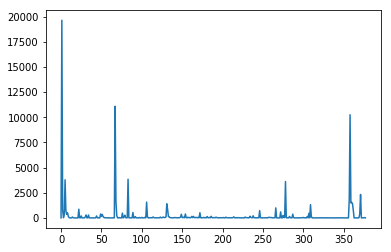

In [27]:
plt.plot(aggregated_loss)
plt.show()